# Part 1: Heart Disease Prediction

In [70]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [7]:
# read data provided on Moodle 
df = pd.read_csv("data/heart_failure/train_val_split.csv")
df_test = pd.read_csv("data/heart_failure/test_split.csv")

## Q1: Exploratory Data Analysis (3 Pts)

#### Get familiar with the dataset by exploring the different features, their distribution, and the labels (1 Pt).

Features:
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

Class label (target):
- HeartDisease: output class [1: heart disease, 0: Normal]

(taken from Kaggle)

In [8]:
# features and label
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [9]:
# There are no obvious NAs 
# we have int, float and object columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 68.9+ KB


plot feature distributions

In [10]:
# identify numeric and categorical columns
feat_cat = {'Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ST_Slope', 'ExerciseAngina'}
feat_num = {'Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'}
label = 'HeartDisease'
assert len(feat_cat | feat_num) == len(df.columns) - 1

Cholesterol


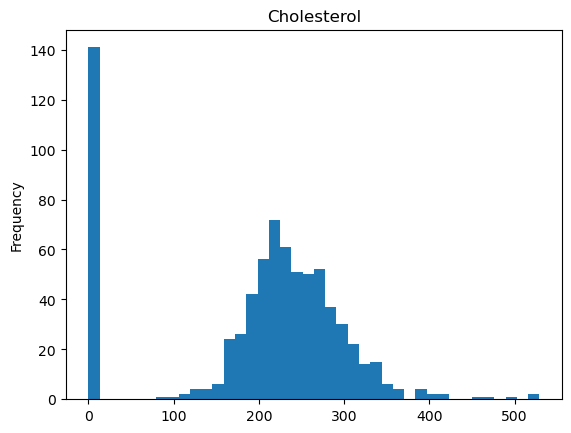

MaxHR


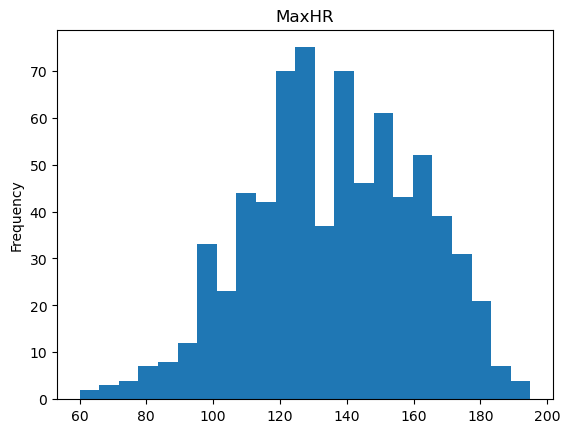

Oldpeak


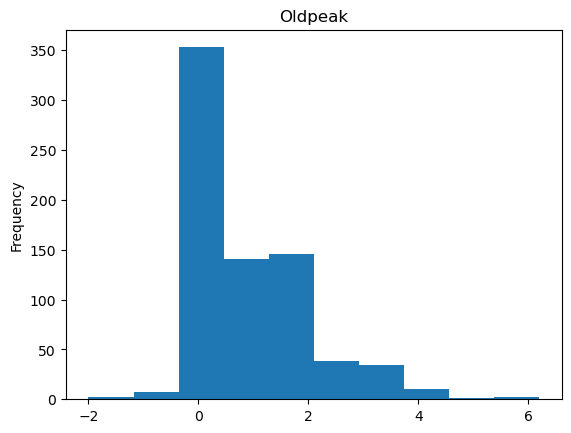

Age


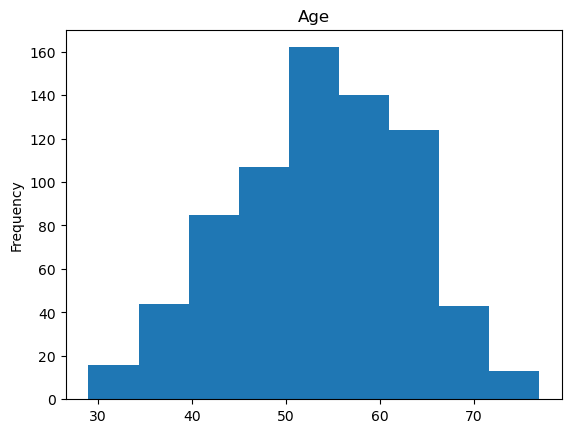

RestingBP


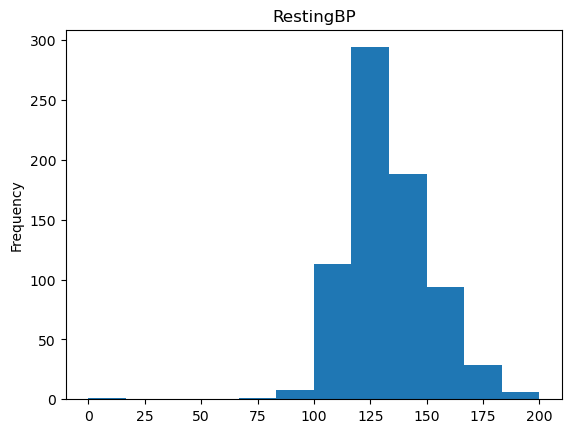

In [11]:
# numeric features
for col in feat_num:
    print(col)
    df[col].plot(kind="hist", title=col, bins=math.floor(len(df[col].unique())/5))
    plt.show()

FastingBS


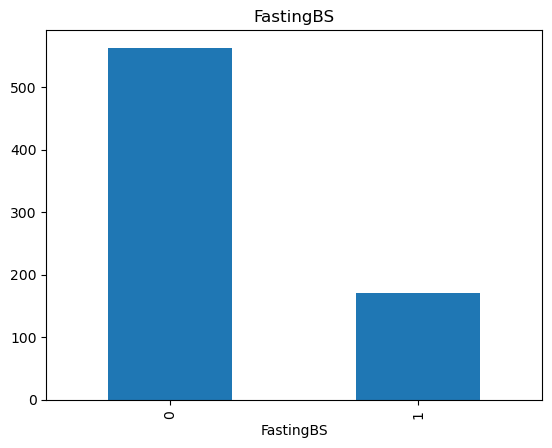

ExerciseAngina


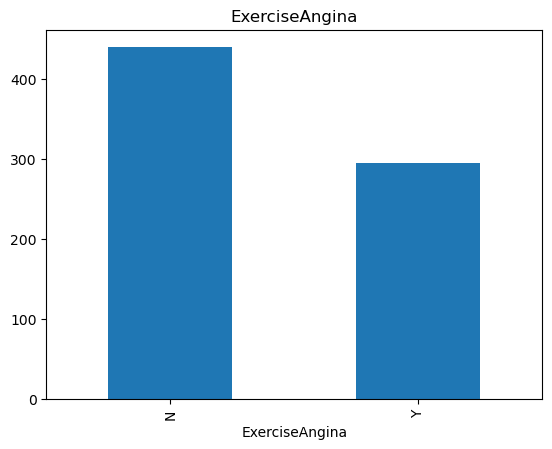

ST_Slope


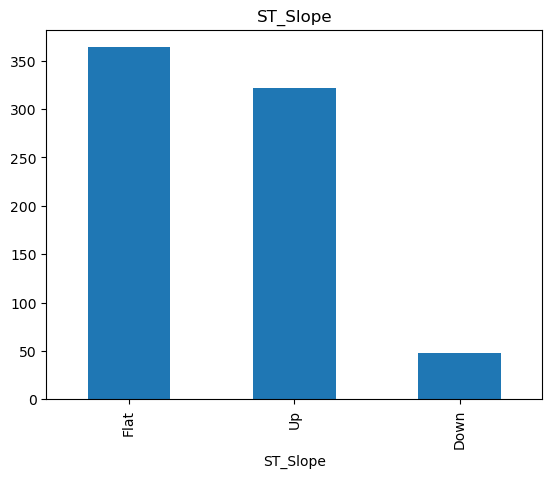

Sex


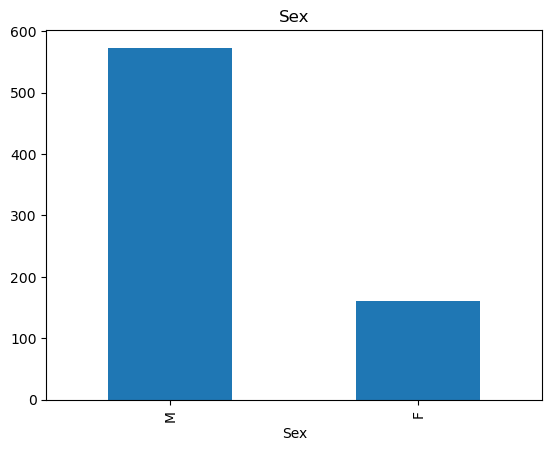

RestingECG


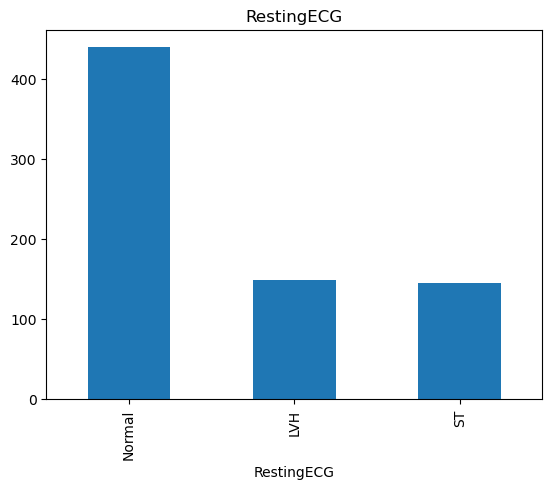

ChestPainType


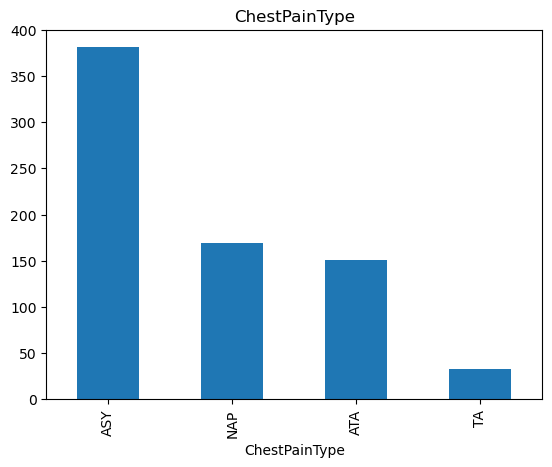

In [12]:
# categorical features
for col in feat_cat:
    print(col)
    df[col].value_counts().plot.bar(title=col)
    plt.show()

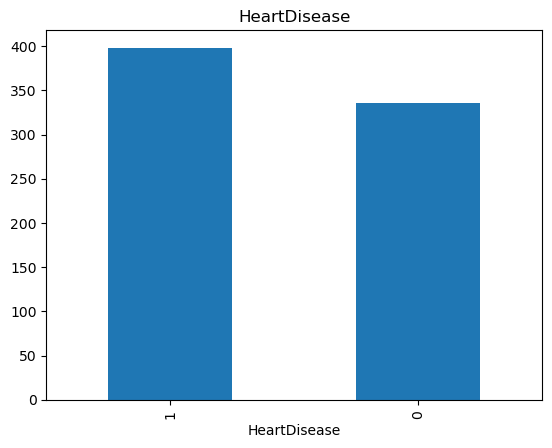

In [13]:
# label looks rather balanced
df[label].value_counts().plot.bar(title=label)
plt.show()

#### Check for common pitfalls like missing or nonsensical data, unusual feature distribution,
outliers, or class imbalance, and describe how to handle them (1 Pt).

Missing data
- RestingBP == 0 makes no sense, but only one occurence => do nothing
- Cholesterol == 0 far apart from usual distribution => looks like missing, add column indicating the missing 

Balance
- categorical features suffer from imbalancedness
- label is almost balanced

141 zeros


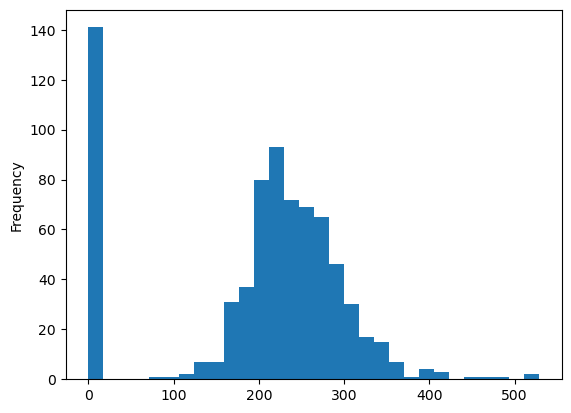

In [14]:
# Cholesterol
print((df["Cholesterol"]==0).sum(), "zeros")

df["Cholesterol"].plot(kind="hist", bins=30)
plt.show()

1 zeros


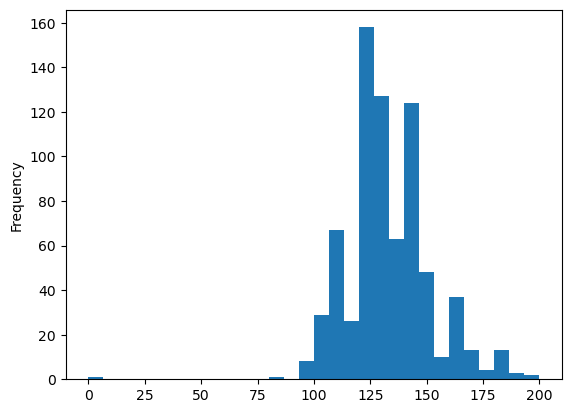

In [15]:
# RestingBP
print((df["RestingBP"]==0).sum(), "zeros")

df["RestingBP"].plot(kind="hist", bins=30)
plt.show()

In [16]:
df.loc[df["RestingBP"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
366,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [17]:
# def handle_missings(df):
#     # replace Cholesterol zeros with median and add column to
#     df["Cholesterol_missing"] = 0
#     df.loc[df["Cholesterol"]==0, "Cholesterol_missing"] = 1
#     med = df["Cholesterol"].median() 
#     df.loc[df["Cholesterol"]==0, "Cholesterol"] = med

#     # fill RestingBP zero with median of population
#     med = df["RestingBP"].median()
#     df.loc[df["RestingBP"]==0, "RestingBP"] = med

#     assert (df["RestingBP"]==0).sum() + (df["Cholesterol"]==0).sum() == 0

#     return df

# df = handle_missings(df)
# df_test = handle_missings(df_test)

In [18]:
def handle_cholesterol(df):
    df["Cholesterol_missing"] = 0
    df.loc[df["Cholesterol"]==0, "Cholesterol_missing"] = 1
    return df
df = handle_cholesterol(df)
df_test = handle_cholesterol(df_test)

In [19]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Cholesterol_missing
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0,0


#### Explain how you preprocess the dataset for the remaining tasks of part 1 (1 Pt).
- split dataset into features and label
- dummy encoding of categorical features: linear model so drop first column

In [174]:
X = df.drop(columns="HeartDisease")
y = df["HeartDisease"]
X_test = df_test.drop(columns="HeartDisease")
y_test = df_test["HeartDisease"]

In [175]:
# dummy encoding
X = pd.get_dummies(X, columns=list(feat_cat), drop_first=True)
X_test = pd.get_dummies(X_test, columns=list(feat_cat), drop_first=True)

## Q2: Logistic Lasso Regression (5 Pts)

#### Describe which preprocessing steps are crucial (1 Pt) to ensure comparability of feature coefficients.

standardization

The lasso method requires initial standardization of the regressors, so that the penalization scheme is fair to all regressors. For categorical regressors, one codes the regressor with dummy variables and then standardizes the dummy variables.

In [176]:
# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

feature_names = scaler.feature_names_in_

#### fit a Lasso regression model with l1 regularization (1 Pt) on the dataset

In [23]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(X, y)

LogisticRegression(penalty='l1', solver='liblinear')

#### Provide performance metrics such as f1-score or balanced accuracy (1 Pt)

In [24]:
# make predictions on test set
y_test_pred = log.predict(X_test)

In [25]:
# F1 score: harmonic mean of the precision and recall.
from sklearn.metrics import f1_score
f1_score(y_true=y_test, y_pred=y_test_pred)

0.8622222222222222

In [26]:
# Balanced accuracy score: average of recall obtained on each class.
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_true=y_test, y_pred=y_test_pred)

0.8192874692874693

#### Visualize the importance of the different features and argue how they contribute to the model's output. (1 Pt)

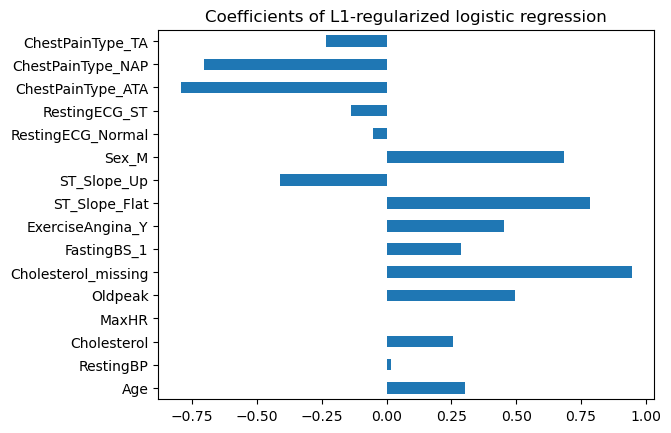

In [27]:
pd.Series(log.coef_[0], index=feature_names, name="importances")\
    .plot.barh(title="Coefficients of L1-regularized logistic regression")
plt.show()

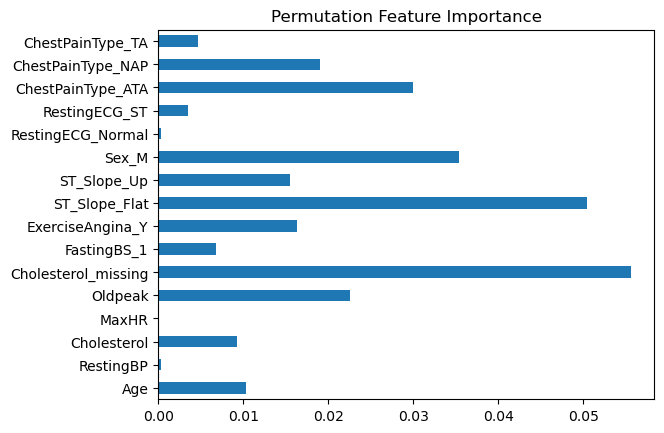

In [28]:
from sklearn.inspection import permutation_importance
pd.Series(permutation_importance(log, X, y)["importances_mean"], index=feature_names, name="importances")\
    .plot.barh(title="Permutation Feature Importance")
plt.show()

Consider the following setting: A researcher is interested in the important variables and their influence on the label. They have fitted the Logistic Lasso Regression to determine the important variables. Then, they train a Logistic Regression solely on these variables and use this model to make conclusions. 
#### Elaborate why this would be a good or bad idea (1 Pt).

- Bad idea: It is not guaranteed that Lasso retrieves the true relevant feature set. We only learn associations, not causal relationships. If we omit the features with low coefficient values, we might omit variables relevant for causal interpretation.
- Good idea: more interpretability as we have less features now

## Q3: Multi-Layer Perceptrons (5 Pts)

#### Implement a simple MLP, train it on the dataset, and report test set performance (2 Pt).

In [29]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(128,64), activation='relu', solver='adam', alpha=0.0001, 
    batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
    max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, 
    momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
    epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

mlp.fit(X,y)

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [30]:
# make predictions on test set
y_test_mlp_pred = mlp.predict(X_test)

In [31]:
# F1 score: harmonic mean of the precision and recall.
from sklearn.metrics import f1_score
f1_score(y_true=y_test, y_pred=y_test_mlp_pred)

0.8214285714285714

In [32]:
# Balanced accuracy score: average of recall obtained on each class.
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_true=y_test, y_pred=y_test_mlp_pred)

0.7695331695331695

#### Then, visualize SHAP explanations of the outputs of two positive and negative samples and feature importances of the overall model (2 Pt).

In [33]:
import shap

In [46]:
explainer = shap.Explainer(mlp.predict, X, feature_names=feature_names)
shap_values = explainer(X)

Permutation explainer: 735it [00:31, 15.88it/s]                         


In [53]:
# get two positive and negative samples
index_negatives = np.random.choice(y[y == 0].index, 2)
index_positives = np.random.choice(y[y == 1].index, 2)

In [58]:
feature_names

array(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',
       'Cholesterol_missing', 'FastingBS_1', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up', 'Sex_M', 'RestingECG_Normal',
       'RestingECG_ST', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA'], dtype=object)

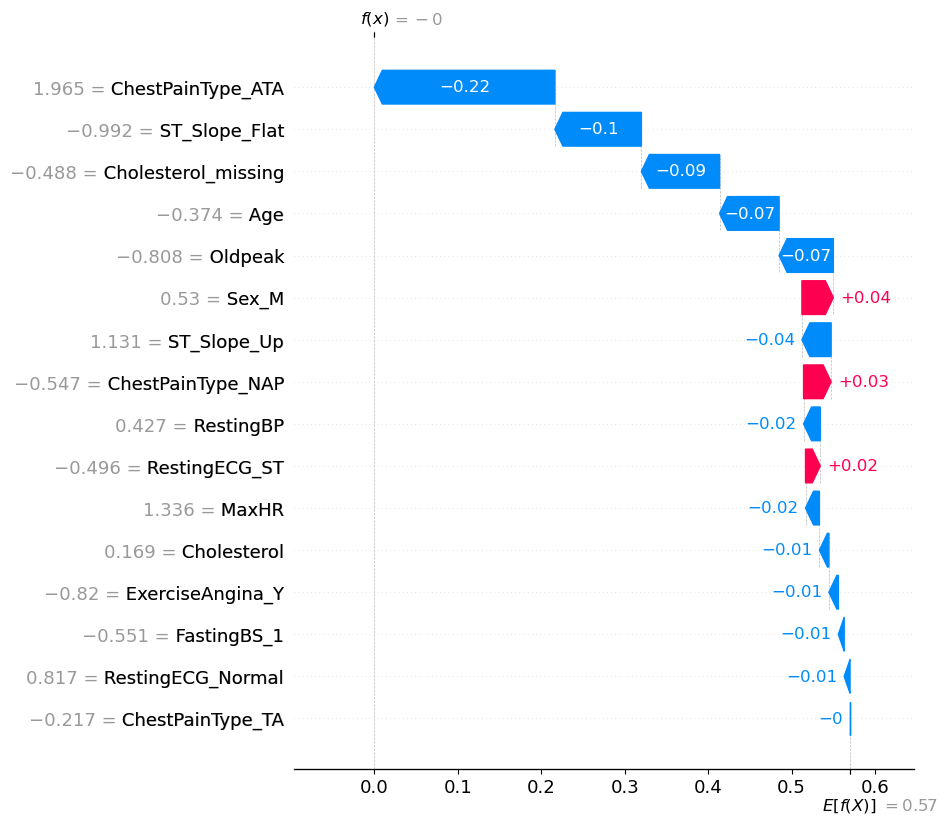

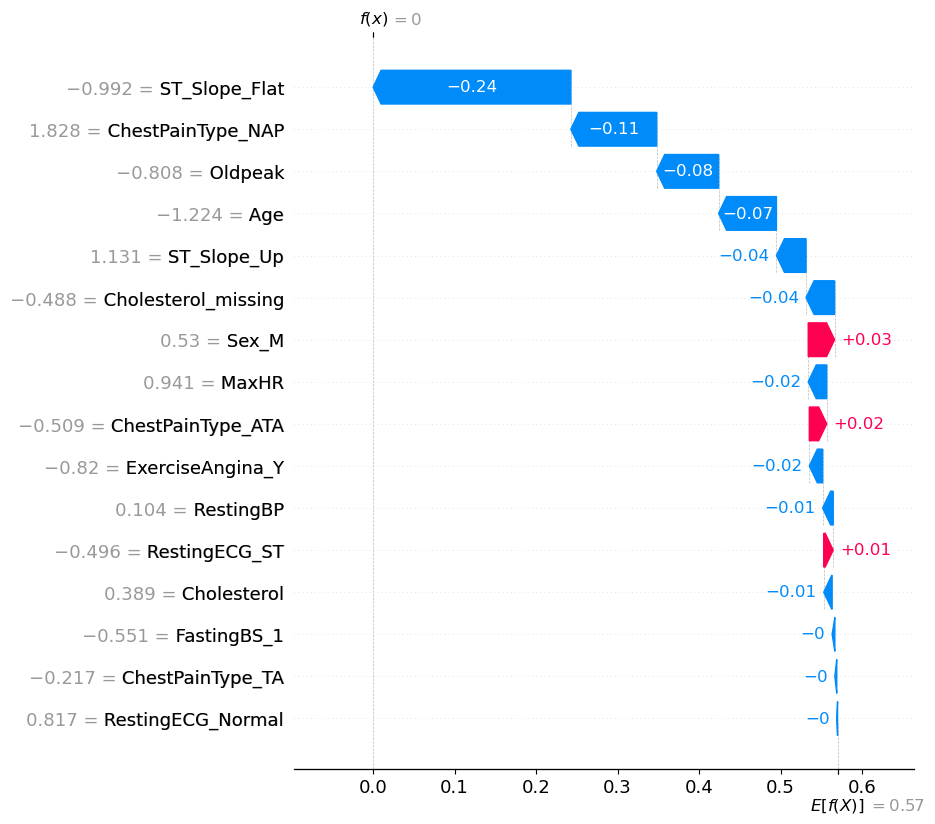

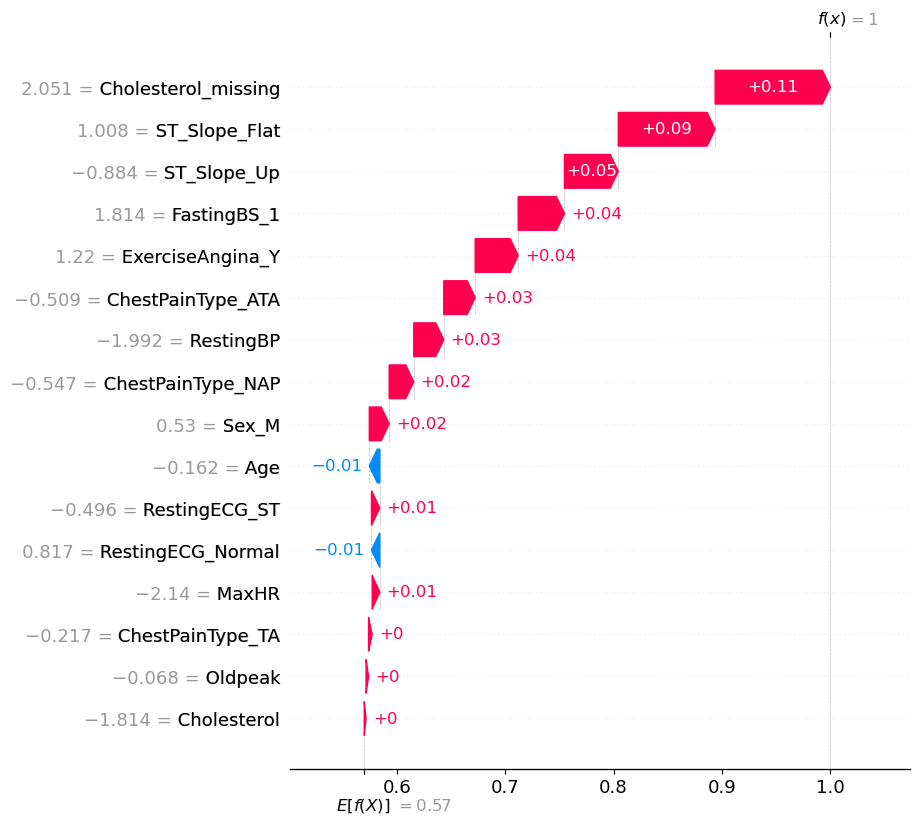

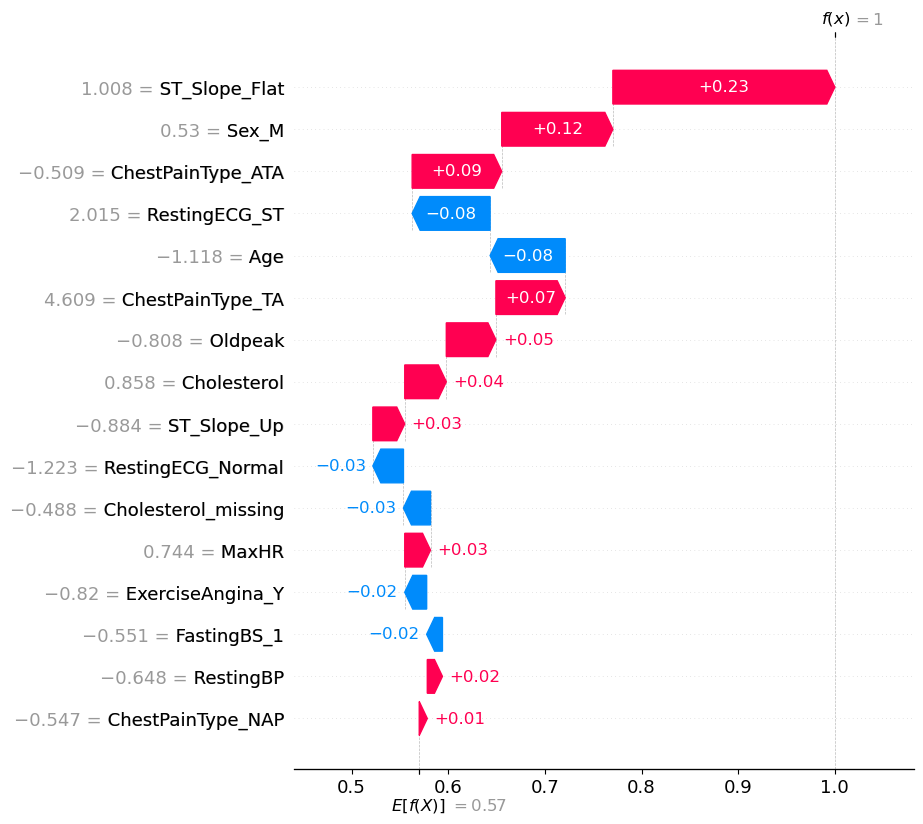

In [56]:
for ix in list(index_negatives) + list(index_positives):
    shap.plots.waterfall(shap_values[ix], max_display=20)
    plt.show()

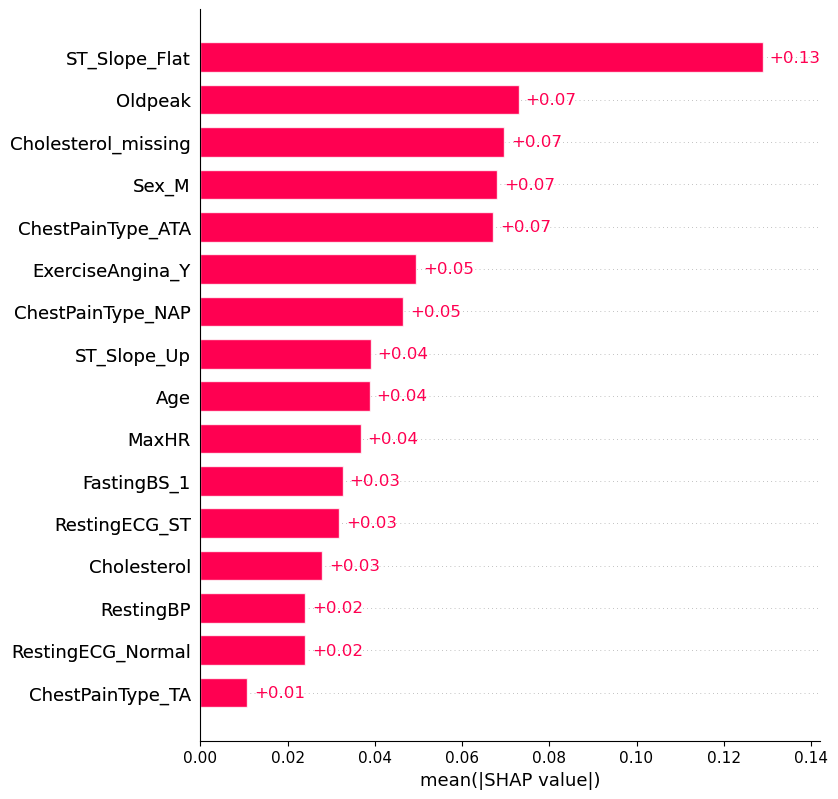

In [54]:
# feauture importances of the overall model = mean shapley value over all data instances
shap.plots.bar(shap_values, max_display=None)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


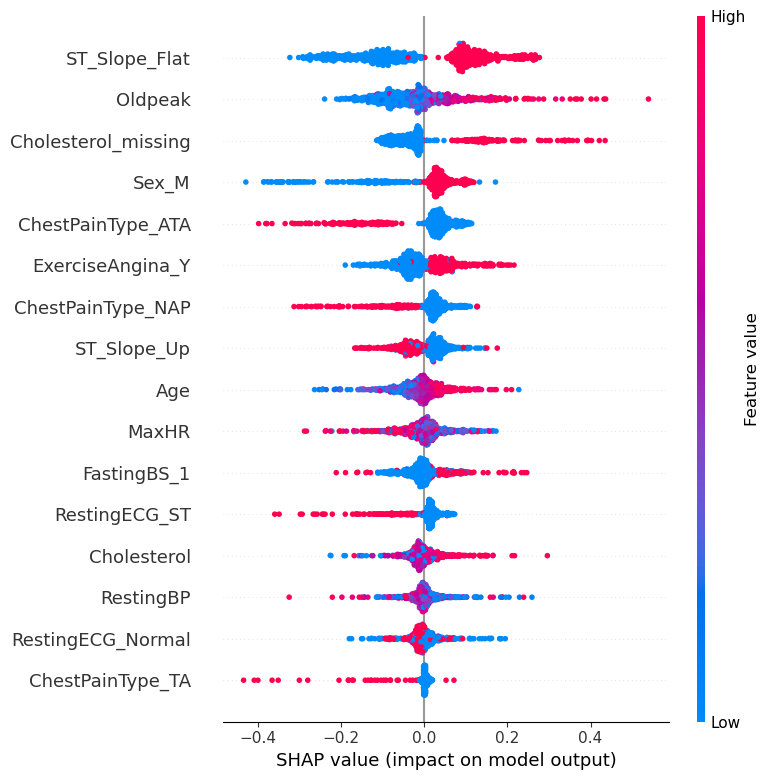

In [57]:
# SHAP values over all data
shap.summary_plot(shap_values)

#### Are feature importances consistent across different predictions and compared to overall importance values (1 Pt)?
We look at three most important feature for individual explanations and overall feature importance:
- the order and set of the three most important features is not consistent across the 4 predictions and also not consistent with the overall feature importance
  - e.g. Sex_M, ChestPainType_NAP, ST_Slope_Up appear only once
  - e.g. Oldpeak is second most important feature and also appears only once
- however, there is significant overlap; e.g. ST_Slope_Flat is the most important feature and appears for all predictions

Negative sample 1:
- ChestPainType_ATA
- ST_Slope_Flat
- Cholesterol_missing

Negative sample 2:
- ST_Slope_Flat
- ChestPainType_NAP
- Oldpeak

Positive sample 1:
- Cholesterol_missing
- ST_Slope_Flat
- ST_Slope_Up

Positive sample 2:
- ST_Slope_Flat
- Sex_M
- ChestPainType_ATA

Overall feature importance (mean shapley value across all data)
- ST_Slope_Flat
- Oldpeak
- Cholesterol_missing

## Q4: Neural Additive Models (7 Pts)

#### Read the paper about NAMs, implement the model, and train it on the dataset (3 Pt).

In [177]:
# X = df.drop(columns="HeartDisease")
# y = df["HeartDisease"]
# X_test = df_test.drop(columns="HeartDisease")
# y_test = df_test["HeartDisease"]

# # dummy encoding
# X = pd.get_dummies(X, columns=list(feat_cat), drop_first=False)
# X_test = pd.get_dummies(X_test, columns=list(feat_cat), drop_first=False)

In [152]:
# based on fork of Google Research implementation of paper
# https://github.com/lemeln/nam/tree/main
 
from nam.wrapper import NAMClassifier

random_state = 0

model = NAMClassifier(
            num_epochs=20,
            num_learners=1,
            metric='accuracy',
            early_stop_mode='max',
            monitor_loss=False,
            n_jobs=10,
            random_state=random_state
        )

model.fit(X, y)

In [153]:
sk_metrics.roc_auc_score(y_test, model.predict_proba(X_test))

0.8977886977886977

In [154]:
# make predictions on test set
y_test_nam_pred = model.predict(X_test)

In [155]:
# F1 score: harmonic mean of the precision and recall.
f1_score(y_true=y_test, y_pred=y_test_nam_pred)

0.8596491228070176

In [156]:
# Balanced accuracy score: average of recall obtained on each class.
balanced_accuracy_score(y_true=y_test, y_pred=y_test_nam_pred)

0.8103194103194102

#### Utilize the interpretability of NAMs to visualize the feature importances (2 Pt).

Dependence plots

In [180]:
model.num_inputs

16

In [187]:
def sample_dependence_plot_data(self, feature_index, scaler) -> None:
    num_samples = 1000
    X = np.zeros((num_samples, self.num_inputs))
    for i in range(self.num_inputs):
        X[:, i] = np.linspace(-3.0, 3.0, num_samples)
    
    # inverse scaling
    X = scaler.inverse_transform(X)

    feature_outputs = []
    for model in self.models:
        # (examples, tasks, features)
        _, fnns_out = model.forward(torch.tensor(X, dtype=torch.float32))
        if self.num_tasks == 1:
            fnns_out = fnns_out.unsqueeze(dim=1)
        # (examples, tasks)
        feature_outputs.append(fnns_out[:, :, feature_index].detach().cpu().numpy())

    # (learners, examples, tasks)
    feature_outputs = np.stack(feature_outputs, axis=0)
    # (examples, tasks)
    y = np.mean(feature_outputs, axis=0).squeeze()
    conf_int = np.std(feature_outputs, axis=0).squeeze()
    # TODO: Scale conf_int according to units of y

    # X = self._preprocessor.inverse_transform(X)
    
    return {'x': X[:, feature_index], 'y': y, 'conf_int': conf_int}

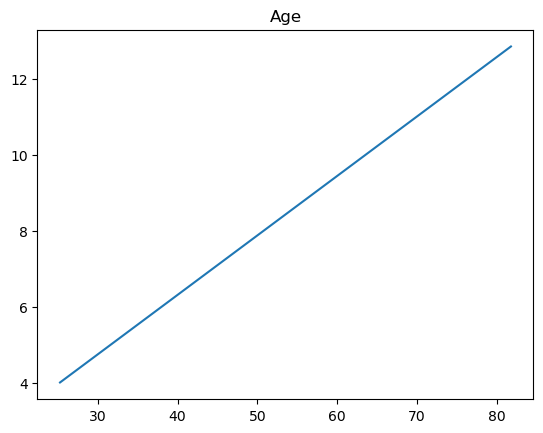

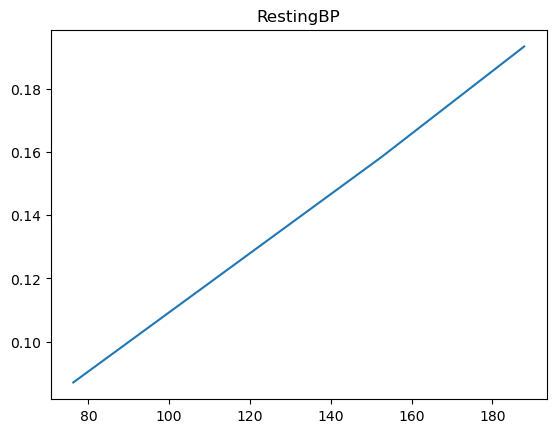

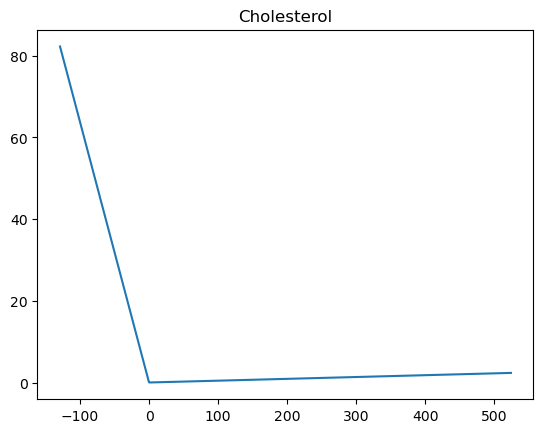

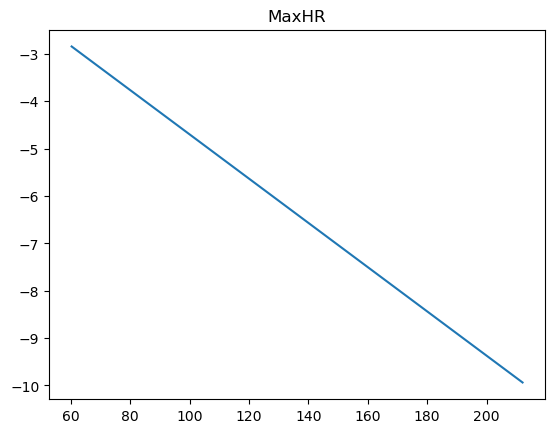

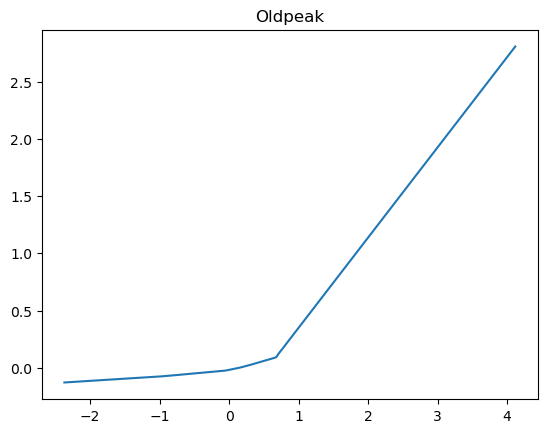

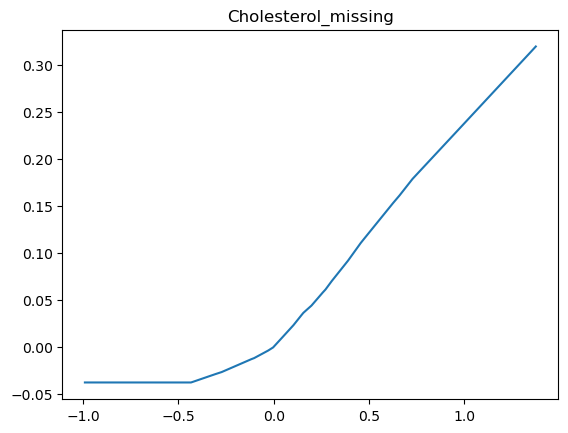

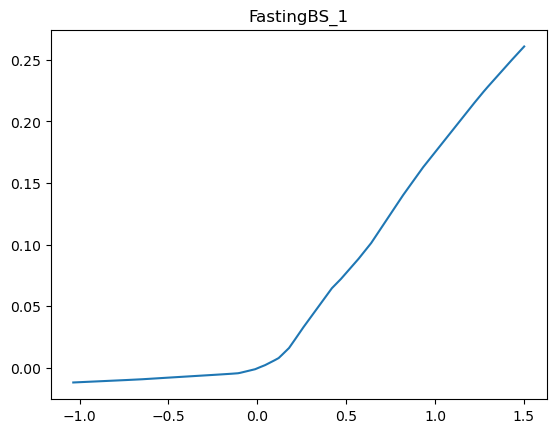

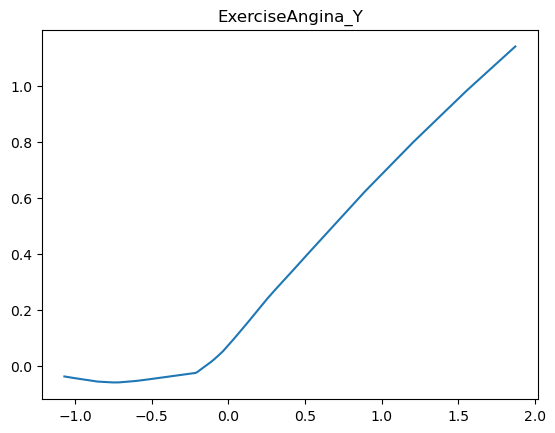

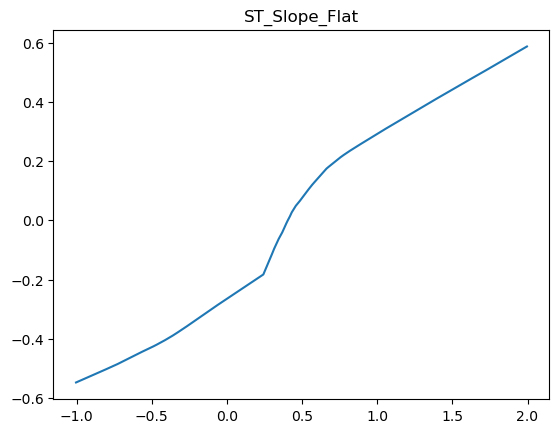

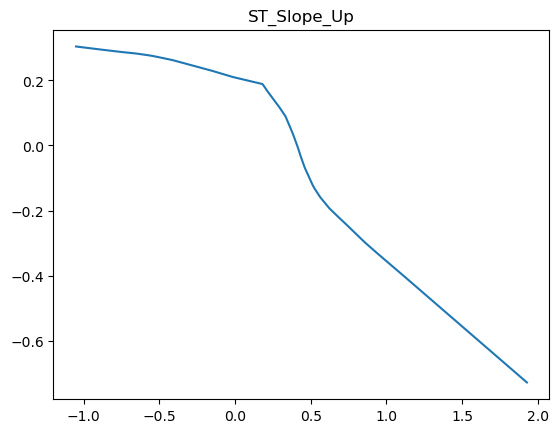

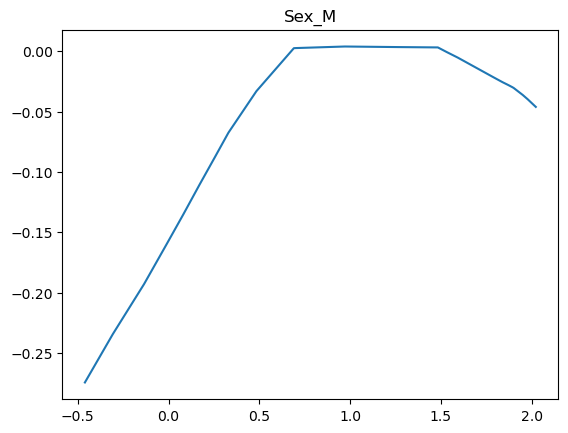

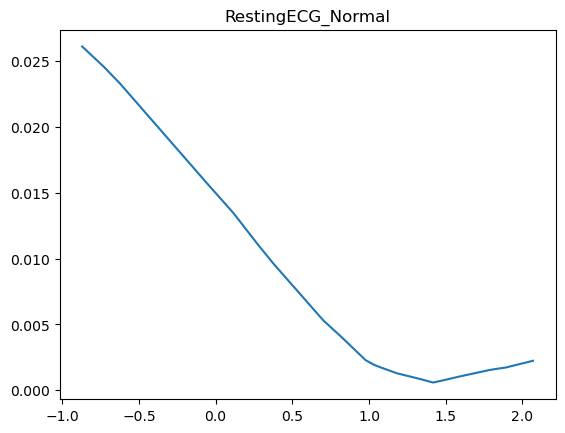

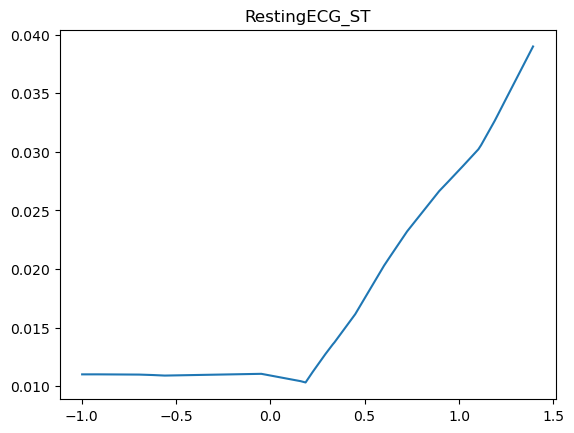

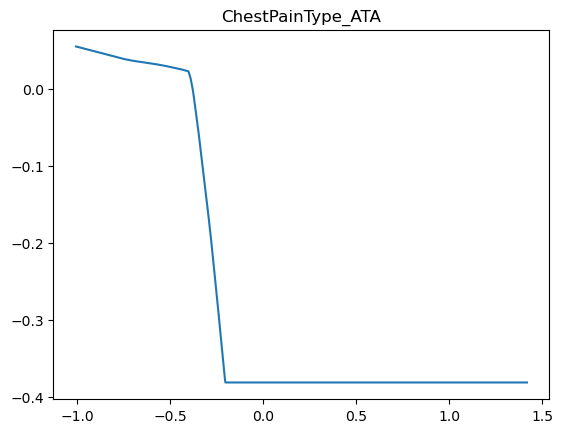

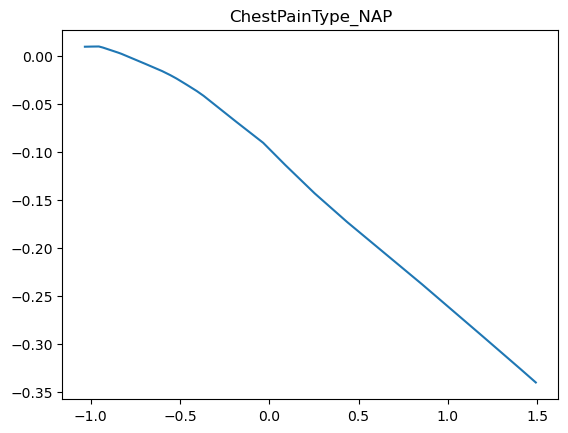

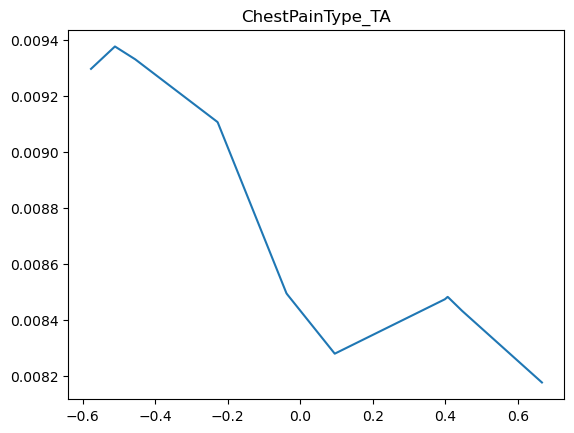

In [191]:
# original scale
for ix, feat in enumerate(feature_names):
    dat = sample_dependence_plot_data(model, feature_index=ix, scaler=scaler)
    plt.plot(dat["x"], dat["y"])
    plt.title(feat)
    plt.show()

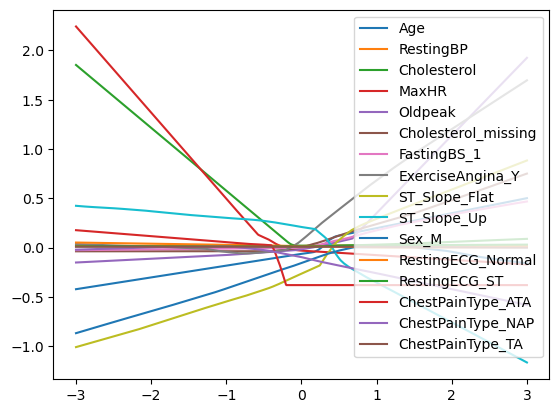

In [190]:
# transformed scale

# for ix, feat in enumerate(feature_names):
    # plt.plot(model.plot(ix)["x"], model.plot(ix)["y"])
    # plt.title(feat)
    # plt.show()

# for ix, feat in enumerate(feature_names):
#     plt.plot(model.plot(ix)["x"], model.plot(ix)["y"], label=feat)
# plt.legend()

In [ ]:
# TODO: global feature importances

#### Conceptually, how does the model compare to Logistic Regression and MLPs (1 Pt)?
A generalized additive model (GAM) is of the form $g(E[y]) = \beta + f_1(x_1) + f_2(x_2) + \cdots + f_k(x_k)$.
- Logistic regression is a generalized linear model with the logit function $g(p) = log(p/(1-p))$ as link. It is a GAM with $f_i$ restricted to be linear.
- Multi layer perceptrons (MLP) are feed-forward neural networks that share their weights among all the input features.
- Neural additive models (NAMs) are linear combinations of neural networks $f_i$ that attend to single input features.

NAM vs. logistic regression
- NAMs and logistic regression are GAMs and thus both have separate weights for separate features; NAMs parametrize the functions $f_i$ with non-linear neural networks and are thus able to fit arbitrarily complex relationships between the feature and the target; logistic regression in contrast is a GAM with $f_i$ restricted to be linear

NAM vs. MLP
- NAMs have different networks for different features whereas MLPs process all input features at once and share their weights among the input features.
- NAMs are GAMs, MLP are not. 

In contrast to MLPs and logistic regression, NAMs can be extended to multitask learning by allowing multiple subnets per input feature.

#### Why are NAMs more interpretable than MLPs despite being based on non-linear neural networks (1 Pt)?
- NAMs have different networks for each feature and thus one can plot $f_i(x_i)$ vs. $x_i$ and thus inspect the relationship between input and output. This makes NAMs interpretable.
- MLPs process all input features at once and weights are shared among these. As features depend on each other, it is harder to explain the impact of one feature on the prediction.